# Rotation Prediction Pipeline

End-to-end pipeline comparing **10-minute** vs **15-minute** opening windows across the full 3-year MNQ dataset (Jan 2023 – Jan 2026).

**Pipeline stages:**
1. `mp2b_IBH_IBL.py` — Initial Balance metrics & opening range
2. `mp2a_previous_day_levels.py` — Prior-day contextual levels
3. Feature engineering (same 5 features used by `mp3_analysis_variables.py`)
4. Model training — Decision Tree & Random Forest with SMOTE
5. Cross-validation report & side-by-side comparison
6. Best model export

In [1]:
import subprocess, os, sys, pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings("ignore", category=FutureWarning)

BASE_DIR = os.path.abspath(".")
CSV_PATH = os.path.join(BASE_DIR, "MNQ_1min_2023Jan_2026Jan.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Full 3-year range
START_DATE = "2023-01-02"
END_DATE   = "2026-01-15"

# Opening windows to compare
OPENING_WINDOWS = [10, 15]

# Feature columns (same as mp3 / rotation_prediction_w_smote)
FEATURE_COLS = [
    "relative_ib_volume",
    "normalized_distance",
    "opening_bar_open_close",
    "opening_bar_volume",
    "prev_session_volume",
]

print(f"Data file:  {CSV_PATH}")
print(f"Date range: {START_DATE} → {END_DATE}")
print(f"Opening windows: {OPENING_WINDOWS} minutes")

Data file:  /home/user/initialbalanceanalysis/MNQ_1min_2023Jan_2026Jan.csv
Date range: 2023-01-02 → 2026-01-15
Opening windows: [10, 15] minutes


## 1. Run Pipeline Stages (mp2b → mp2a) for Each Opening Window

In [2]:
def run_pipeline(opening_minutes: int) -> str:
    """Run mp2b then mp2a for a given opening window. Returns path to phase2 CSV."""
    tag = f"{opening_minutes}min"
    ib_out = os.path.join(OUTPUT_DIR, f"ib_metrics_{tag}.csv")
    p2_out = os.path.join(OUTPUT_DIR, f"phase2_{tag}.csv")

    # --- mp2b: IB metrics ---
    cmd_mp2b = [
        sys.executable, os.path.join(BASE_DIR, "mp2b_IBH_IBL.py"),
        "--csv", CSV_PATH,
        "--start-date", START_DATE,
        "--end-date", END_DATE,
        "--opening-window-minutes", str(opening_minutes),
        "--output", ib_out,
    ]
    print(f"  mp2b ({tag})... ", end="", flush=True)
    result = subprocess.run(cmd_mp2b, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"FAILED\n{result.stderr}")
        raise RuntimeError(f"mp2b failed for {tag}")
    print("done")

    # --- mp2a: prior-day levels ---
    cmd_mp2a = [
        sys.executable, os.path.join(BASE_DIR, "mp2a_previous_day_levels.py"),
        "--csv", CSV_PATH,
        "--ib-metrics", ib_out,
        "--output", p2_out,
    ]
    print(f"  mp2a ({tag})... ", end="", flush=True)
    result = subprocess.run(cmd_mp2a, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"FAILED\n{result.stderr}")
        raise RuntimeError(f"mp2a failed for {tag}")
    print("done")

    return p2_out


phase2_paths = {}
for win in OPENING_WINDOWS:
    print(f"\nRunning pipeline for {win}-minute opening window:")
    phase2_paths[win] = run_pipeline(win)

print("\nAll pipeline runs complete.")
for win, path in phase2_paths.items():
    print(f"  {win} min → {path}")


Running pipeline for 10-minute opening window:
  mp2b (10min)... 

done
  mp2a (10min)... 

done

Running pipeline for 15-minute opening window:
  mp2b (15min)... 

done
  mp2a (15min)... 

done

All pipeline runs complete.
  10 min → /home/user/initialbalanceanalysis/outputs/phase2_10min.csv
  15 min → /home/user/initialbalanceanalysis/outputs/phase2_15min.csv


## 2. Load & Prepare Features

In [3]:
def load_and_prepare(csv_path: str) -> tuple[pd.DataFrame, pd.Series]:
    """Load phase2 CSV and return (X, y) with the 5-feature vector and rotation target."""
    df = pd.read_csv(csv_path)

    # Normalized distance: nearest_prior_level_to_open_distance / (prev_pdh - prev_pdl)
    df["prev_range"] = df["prev_pdh"] - df["prev_pdl"]
    df["prev_range"] = df["prev_range"].replace(0, np.nan)
    df["normalized_distance"] = (
        df["nearest_prior_level_to_open_distance"] / df["prev_range"]
    )
    df["normalized_distance"] = df["normalized_distance"].fillna(0)

    X = df[FEATURE_COLS].copy()
    y = df["rotation"].copy()

    # Drop rows with NaN features
    mask = X.dropna().index
    X = X.loc[mask]
    y = y.loc[mask]

    return X, y


datasets = {}
for win in OPENING_WINDOWS:
    X, y = load_and_prepare(phase2_paths[win])
    datasets[win] = (X, y)
    rot_count = y.sum()
    print(f"{win}-min window: {len(y)} sessions, {rot_count} rotations ({rot_count/len(y)*100:.1f}%), {len(y)-rot_count} non-rotations ({(len(y)-rot_count)/len(y)*100:.1f}%)")

10-min window: 765 sessions, 157 rotations (20.5%), 608 non-rotations (79.5%)
15-min window: 765 sessions, 157 rotations (20.5%), 608 non-rotations (79.5%)


## 3. Cross-Validation Report

We use `imblearn.pipeline.Pipeline` so that SMOTE is applied **inside** each CV fold (only on training data), preventing data leakage.

Scoring metrics:
- **F1** — harmonic mean of precision and recall; the single best metric for imbalanced binary classification
- **Accuracy** — overall correctness (can be misleading when classes are imbalanced)
- **Precision** — of predicted rotations, how many actually were
- **Recall** — of actual rotations, how many did the model catch

In [4]:
def run_cross_validation(X, y, model, model_name, n_splits=5):
    """Run stratified K-fold CV with SMOTE inside each fold. Returns scores dict."""
    pipeline = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("model", model),
    ])
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scoring = ["accuracy", "f1", "precision", "recall"]
    results = cross_validate(
        pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False
    )
    return results


# Model configurations
model_configs = {
    "Decision Tree (depth=3)": DecisionTreeClassifier(max_depth=3, random_state=42),
    "Random Forest (100 trees, depth=5)": RandomForestClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
}

cv_results = {}  # {(window, model_name): results_dict}

for win in OPENING_WINDOWS:
    X, y = datasets[win]
    for model_name, model in model_configs.items():
        print(f"CV: {win}-min / {model_name} ... ", end="", flush=True)
        results = run_cross_validation(X, y, model, model_name, n_splits=5)
        cv_results[(win, model_name)] = results
        f1 = results["test_f1"]
        print(f"F1 = {f1.mean():.3f} ± {f1.std():.3f}")

CV: 10-min / Decision Tree (depth=3) ... 

F1 = 0.440 ± 0.043
CV: 10-min / Random Forest (100 trees, depth=5) ... 

F1 = 0.443 ± 0.032
CV: 15-min / Decision Tree (depth=3) ... 

F1 = 0.428 ± 0.035
CV: 15-min / Random Forest (100 trees, depth=5) ... 

F1 = 0.444 ± 0.021


In [5]:
# Build comparison table
rows = []
for (win, model_name), res in cv_results.items():
    rows.append({
        "Opening Window": f"{win} min",
        "Model": model_name,
        "Accuracy": f"{res['test_accuracy'].mean():.3f} ± {res['test_accuracy'].std():.3f}",
        "F1": f"{res['test_f1'].mean():.3f} ± {res['test_f1'].std():.3f}",
        "Precision": f"{res['test_precision'].mean():.3f} ± {res['test_precision'].std():.3f}",
        "Recall": f"{res['test_recall'].mean():.3f} ± {res['test_recall'].std():.3f}",
    })

cv_table = pd.DataFrame(rows)
print("\n5-Fold Stratified Cross-Validation (SMOTE applied per fold)")
print("=" * 90)
display(cv_table)


5-Fold Stratified Cross-Validation (SMOTE applied per fold)


,Opening Window,Model,Accuracy,F1,Precision,Recall
0,10 min,Decision Tree (depth=3),0.664 ± 0.022,0.440 ± 0.043,0.334 ± 0.026,0.649 ± 0.098
1,10 min,"Random Forest (100 trees, depth=5)",0.672 ± 0.027,0.443 ± 0.032,0.341 ± 0.025,0.636 ± 0.064
2,15 min,Decision Tree (depth=3),0.654 ± 0.031,0.428 ± 0.035,0.325 ± 0.023,0.636 ± 0.092
3,15 min,"Random Forest (100 trees, depth=5)",0.671 ± 0.018,0.444 ± 0.021,0.340 ± 0.012,0.643 ± 0.059


### How to read the CV results

| Metric | What it tells you | Why it matters here |
|--------|-------------------|--------------------|
| **F1** | Balance between precision and recall | Primary metric — a low F1 (like the prior 0.42) means the model struggles to reliably identify rotations without also generating false positives |
| **Precision** | "When the model says rotation, how often is it right?" | High precision = fewer false alarms. Important if you act on predictions (e.g., position sizing) |
| **Recall** | "Of all actual rotations, how many does the model catch?" | High recall = fewer missed opportunities. SMOTE boosts this by giving the model more rotation examples |
| **Accuracy** | Overall % correct | Can be misleading — a model that always predicts non-rotation gets ~70% accuracy on an imbalanced set |
| **± std** | Stability across folds | Large std means the model is sensitive to which data it trains on — a sign of overfitting or insufficient data |

**Guidance:**
- F1 > 0.50 is a meaningful improvement over the prior baseline (0.42)
- If Random Forest F1 is materially higher than Decision Tree, the extra complexity is justified
- If 15-min window improves F1, the wider opening range captures more signal about the session's direction
- If std is high (> 0.10), the model may not generalize well to unseen data

## 4. Train Final Models (60/40 Split with SMOTE)

In [6]:
# Train all 4 combinations on 60/40 split
trained_models = {}  # {(window, model_name): {model, X_test, y_test, y_pred, ...}}

for win in OPENING_WINDOWS:
    X, y = datasets[win]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    sm = SMOTE(random_state=42)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

    for model_name, model_template in model_configs.items():
        # Clone the model so each gets fresh parameters
        from sklearn.base import clone
        model = clone(model_template)
        model.fit(X_train_sm, y_train_sm)

        y_pred = model.predict(X_test)
        test_acc = model.score(X_test, y_test)
        train_acc = model.score(X_train_sm, y_train_sm)

        trained_models[(win, model_name)] = {
            "model": model,
            "X_test": X_test,
            "y_test": y_test,
            "y_pred": y_pred,
            "test_acc": test_acc,
            "train_acc": train_acc,
        }
        print(f"{win}-min / {model_name}: train acc = {train_acc:.3f}, test acc = {test_acc:.3f}")

10-min / Decision Tree (depth=3): train acc = 0.776, test acc = 0.654
10-min / Random Forest (100 trees, depth=5): train acc = 0.859, test acc = 0.686


15-min / Decision Tree (depth=3): train acc = 0.775, test acc = 0.654


15-min / Random Forest (100 trees, depth=5): train acc = 0.855, test acc = 0.693


## 5. Decision Tree Reports


  Decision Tree — 10-minute opening window
              precision    recall  f1-score   support

Non-Rotation       0.87      0.66      0.75       242
    Rotation       0.33      0.64      0.44        64

    accuracy                           0.65       306
   macro avg       0.60      0.65      0.59       306
weighted avg       0.76      0.65      0.68       306



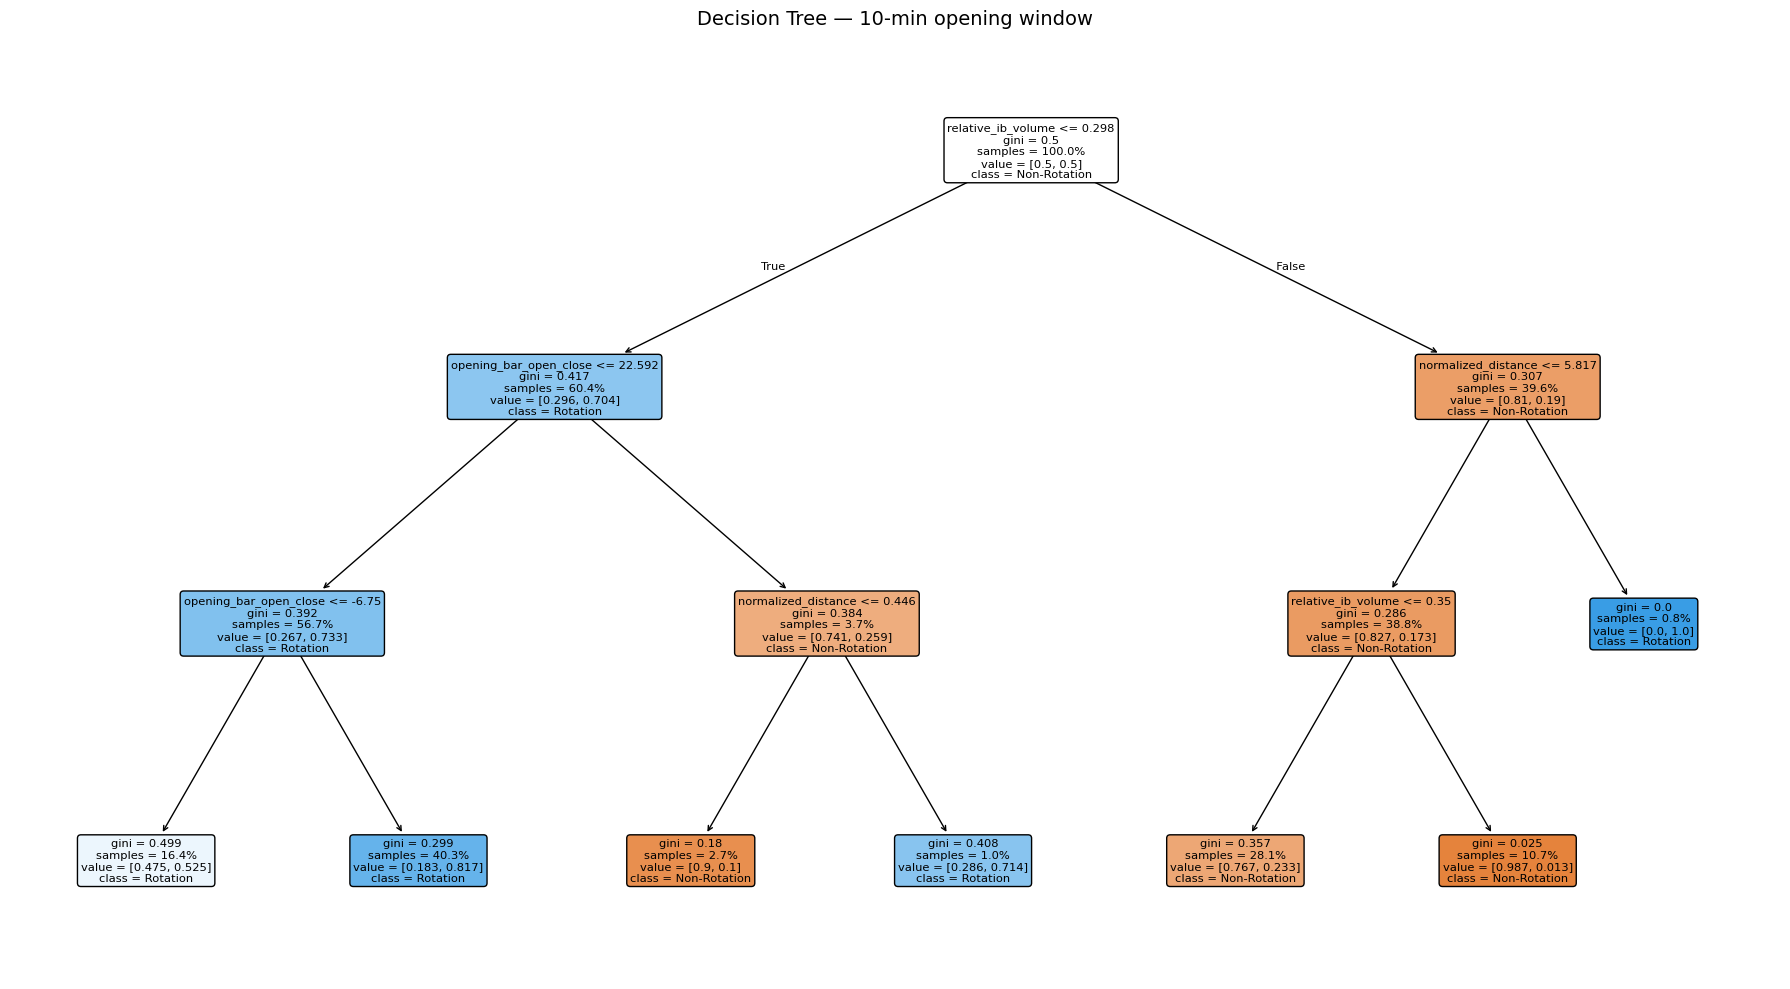


  Decision Tree — 15-minute opening window
              precision    recall  f1-score   support

Non-Rotation       0.87      0.66      0.75       242
    Rotation       0.33      0.64      0.44        64

    accuracy                           0.65       306
   macro avg       0.60      0.65      0.59       306
weighted avg       0.76      0.65      0.68       306



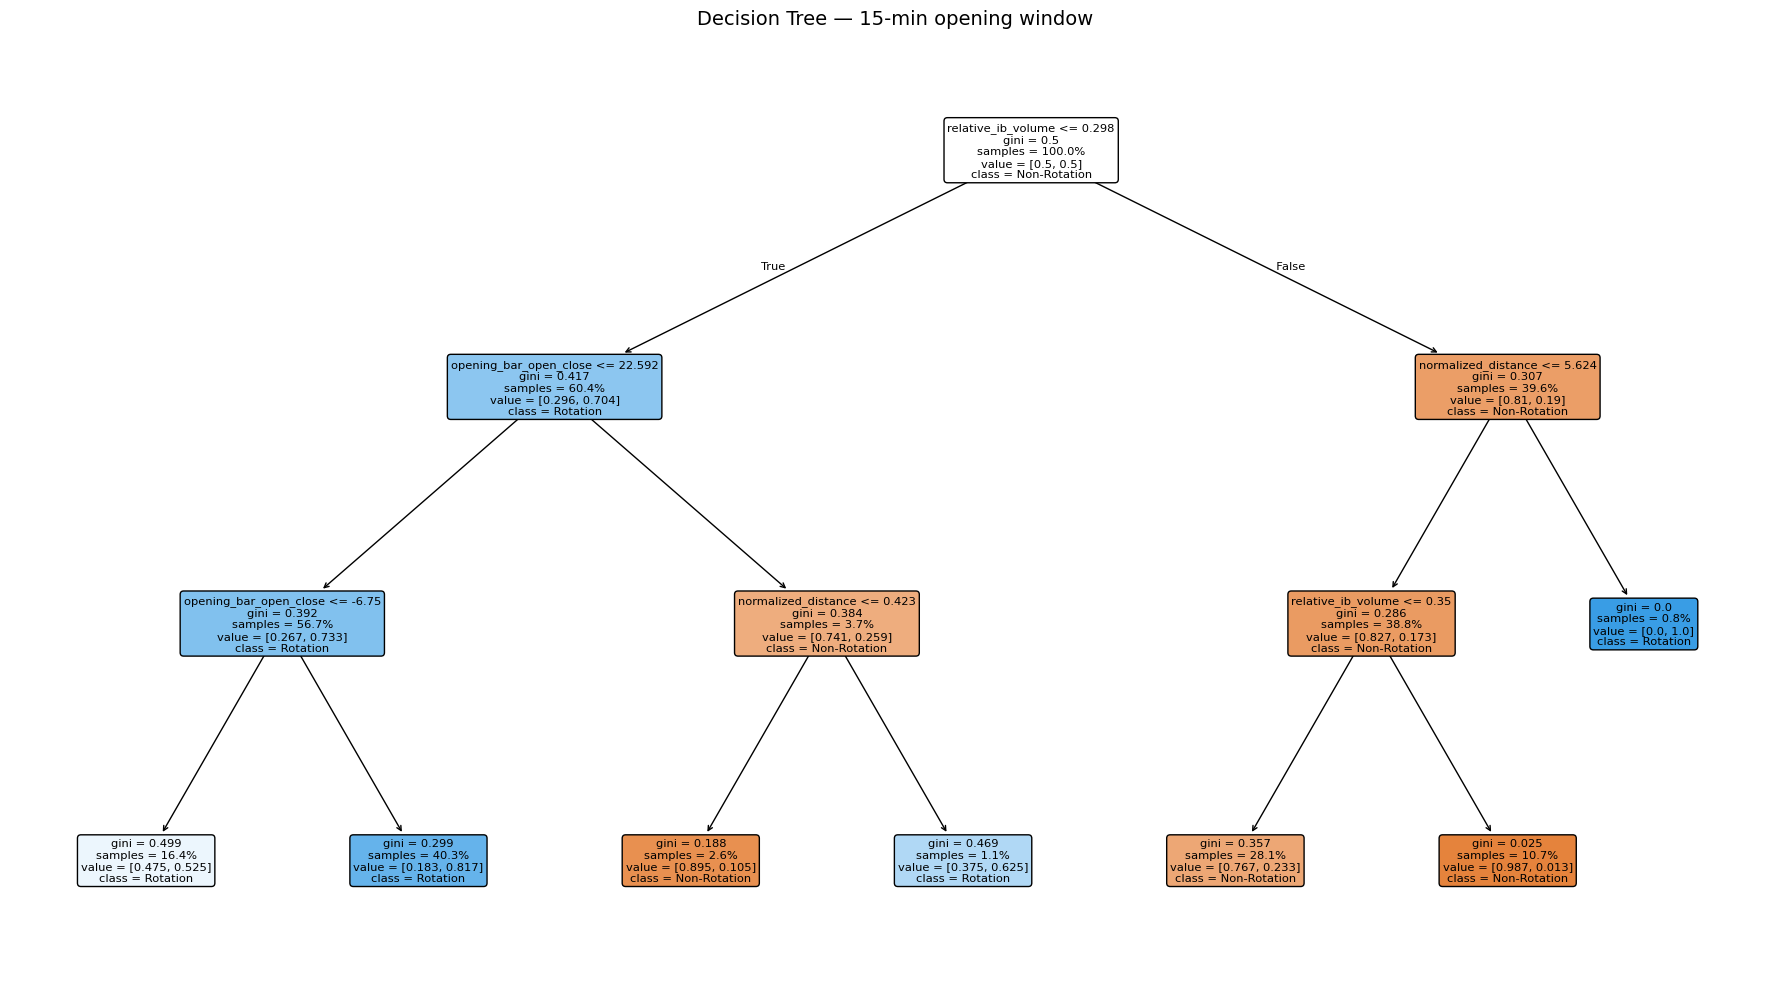

In [7]:
dt_name = "Decision Tree (depth=3)"

for win in OPENING_WINDOWS:
    entry = trained_models[(win, dt_name)]
    model = entry["model"]
    y_test = entry["y_test"]
    y_pred = entry["y_pred"]

    print(f"\n{'='*60}")
    print(f"  Decision Tree — {win}-minute opening window")
    print(f"{'='*60}")
    print(classification_report(
        y_test, y_pred, target_names=["Non-Rotation", "Rotation"]
    ))

    fig, ax = plt.subplots(figsize=(18, 10))
    plot_tree(
        model,
        feature_names=FEATURE_COLS,
        class_names=["Non-Rotation", "Rotation"],
        filled=True,
        proportion=True,
        rounded=True,
        ax=ax,
    )
    ax.set_title(f"Decision Tree — {win}-min opening window", fontsize=14)
    plt.tight_layout()
    plt.show()

## 6. Random Forest Reports


  Random Forest — 10-minute opening window
              precision    recall  f1-score   support

Non-Rotation       0.84      0.74      0.79       242
    Rotation       0.33      0.47      0.38        64

    accuracy                           0.69       306
   macro avg       0.58      0.61      0.59       306
weighted avg       0.73      0.69      0.70       306



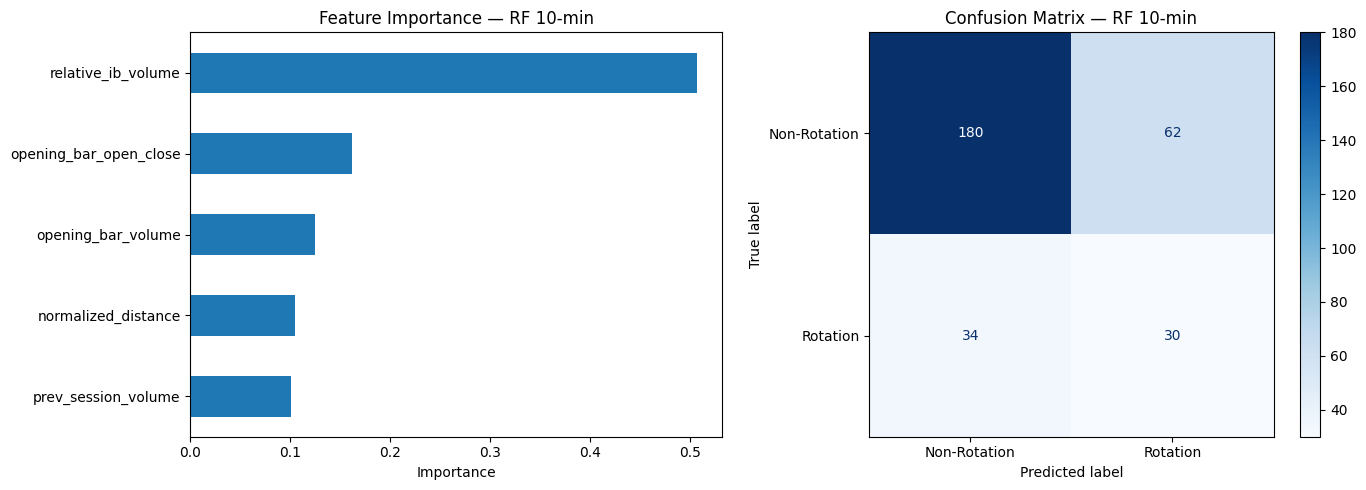


  Random Forest — 15-minute opening window
              precision    recall  f1-score   support

Non-Rotation       0.86      0.74      0.79       242
    Rotation       0.35      0.53      0.42        64

    accuracy                           0.69       306
   macro avg       0.60      0.63      0.61       306
weighted avg       0.75      0.69      0.71       306



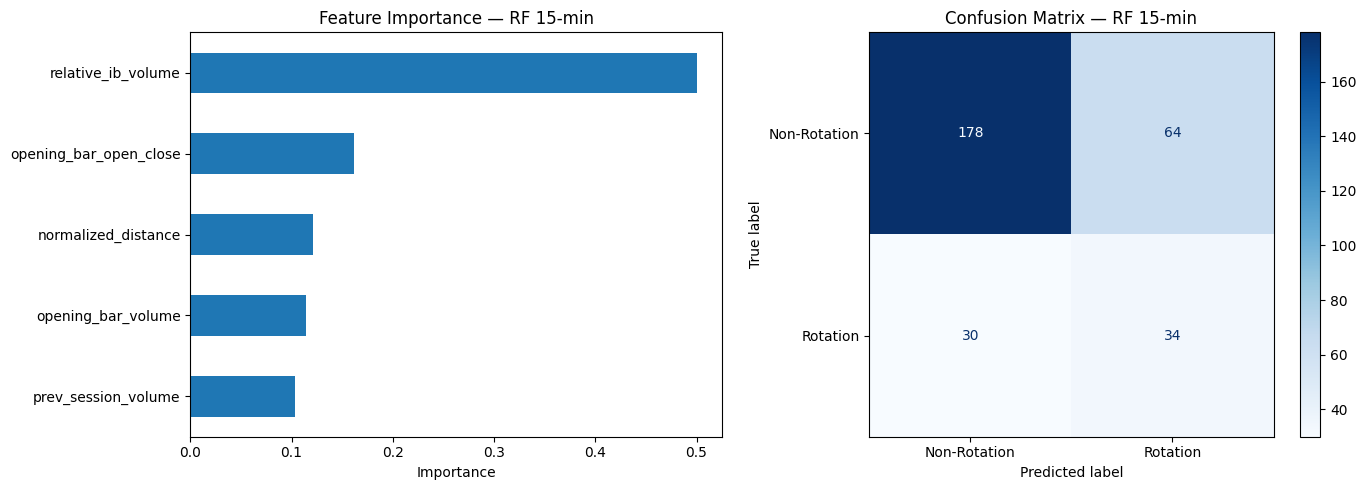

In [8]:
rf_name = "Random Forest (100 trees, depth=5)"

for win in OPENING_WINDOWS:
    entry = trained_models[(win, rf_name)]
    model = entry["model"]
    y_test = entry["y_test"]
    y_pred = entry["y_pred"]

    print(f"\n{'='*60}")
    print(f"  Random Forest — {win}-minute opening window")
    print(f"{'='*60}")
    print(classification_report(
        y_test, y_pred, target_names=["Non-Rotation", "Rotation"]
    ))

    # Feature importances
    importances = pd.Series(model.feature_importances_, index=FEATURE_COLS)
    importances = importances.sort_values(ascending=True)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Feature importance bar chart
    importances.plot.barh(ax=axes[0])
    axes[0].set_title(f"Feature Importance — RF {win}-min")
    axes[0].set_xlabel("Importance")

    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=["Non-Rotation", "Rotation"],
        cmap="Blues",
        ax=axes[1],
    )
    axes[1].set_title(f"Confusion Matrix — RF {win}-min")

    plt.tight_layout()
    plt.show()

## 7. Confusion Matrices — All Models Side by Side

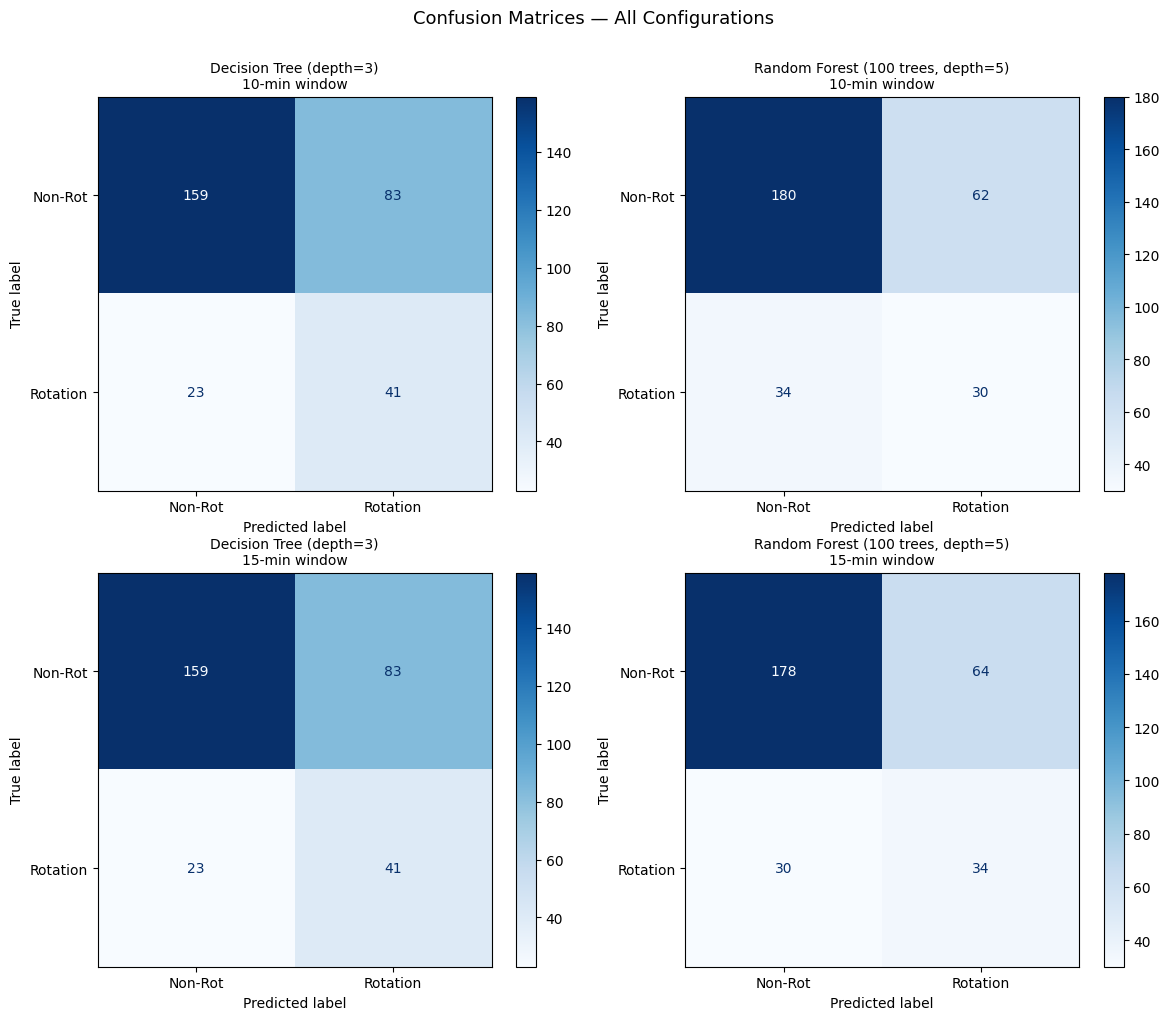

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

combos = [(win, name) for win in OPENING_WINDOWS for name in model_configs.keys()]
for ax, (win, name) in zip(axes.flat, combos):
    entry = trained_models[(win, name)]
    ConfusionMatrixDisplay.from_predictions(
        entry["y_test"], entry["y_pred"],
        display_labels=["Non-Rot", "Rotation"],
        cmap="Blues",
        ax=ax,
    )
    ax.set_title(f"{name}\n{win}-min window", fontsize=10)

plt.suptitle("Confusion Matrices — All Configurations", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## 8. Select & Export Best Model

In [10]:
# Rank by mean CV F1 score
rankings = []
for (win, model_name), res in cv_results.items():
    f1_mean = res["test_f1"].mean()
    f1_std = res["test_f1"].std()
    rankings.append({
        "window": win,
        "model_name": model_name,
        "f1_mean": f1_mean,
        "f1_std": f1_std,
    })

rankings.sort(key=lambda r: r["f1_mean"], reverse=True)

print("Model rankings by CV F1:")
print("-" * 70)
for i, r in enumerate(rankings):
    marker = " ← BEST" if i == 0 else ""
    print(f"  {i+1}. {r['window']}-min / {r['model_name']}: "
          f"F1 = {r['f1_mean']:.3f} ± {r['f1_std']:.3f}{marker}")

best = rankings[0]
best_key = (best["window"], best["model_name"])
best_model = trained_models[best_key]["model"]
best_window = best["window"]

print(f"\nBest configuration: {best['window']}-min / {best['model_name']}")
print(f"CV F1: {best['f1_mean']:.3f} ± {best['f1_std']:.3f}")

Model rankings by CV F1:
----------------------------------------------------------------------
  1. 15-min / Random Forest (100 trees, depth=5): F1 = 0.444 ± 0.021 ← BEST
  2. 10-min / Random Forest (100 trees, depth=5): F1 = 0.443 ± 0.032
  3. 10-min / Decision Tree (depth=3): F1 = 0.440 ± 0.043
  4. 15-min / Decision Tree (depth=3): F1 = 0.428 ± 0.035

Best configuration: 15-min / Random Forest (100 trees, depth=5)
CV F1: 0.444 ± 0.021


In [11]:
# Export best model
model_path = os.path.join(BASE_DIR, "decision_tree_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"Best model saved to: {model_path}")
print(f"Model type: {type(best_model).__name__}")
print(f"Opening window: {best_window} minutes")
print(f"\nNOTE: If the best model uses a 15-min opening window, update")
print(f"mp3_analysis_variables.py line 266 to match:")
print(f'  opening_end_dt = opening_start_dt + timedelta(minutes={best_window})')

Best model saved to: /home/user/initialbalanceanalysis/decision_tree_model.pkl
Model type: RandomForestClassifier
Opening window: 15 minutes

NOTE: If the best model uses a 15-min opening window, update
mp3_analysis_variables.py line 266 to match:
  opening_end_dt = opening_start_dt + timedelta(minutes=15)


## 9. Summary & Next Steps

This pipeline tested 4 configurations:

| | Decision Tree (depth=3) | Random Forest (100 trees, depth=5) |
|---|---|---|
| **10-min window** | baseline | ensemble comparison |
| **15-min window** | wider opening range | wider + ensemble |

**Key takeaways to look for:**
- Does 3 years of data improve the prior 0.42 CV F1? More data helps if the pattern is stable over time.
- Does Random Forest outperform Decision Tree? If so, the extra trees capture feature interactions the single tree misses.
- Does 15-min window help? A wider opening range includes more price action but may also add noise.
- Check the ± std — if it's large, the model is unstable across folds.

**To re-run with different parameters**, modify the constants in cell 1:
- `OPENING_WINDOWS` — add more window sizes (e.g., `[5, 10, 15, 20]`)
- `START_DATE` / `END_DATE` — narrow or widen the date range
- `model_configs` dict in the CV cell — add other models or hyperparameters